In [1]:
import torch
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
from torchvision.datasets.utils import download_url
import torch.nn as nn
import torch.nn.functional as F
import tarfile
%matplotlib inline

In [3]:
import torchvision.datasets as datasets

cifar_trainset = datasets.CIFAR10(root='../data', train=True, download=True,transform=tf.ToTensor()  )
data = cifar_trainset.data / 255 

means = data.mean(axis = (0,1,2)) 
stds = data.std(axis = (0,1,2))
print(f"{means}   {stds}") 

Files already downloaded and verified
[0.49139968 0.48215841 0.44653091]   [0.24703223 0.24348513 0.26158784]


In [4]:
len(cifar_trainset)

50000

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


truck


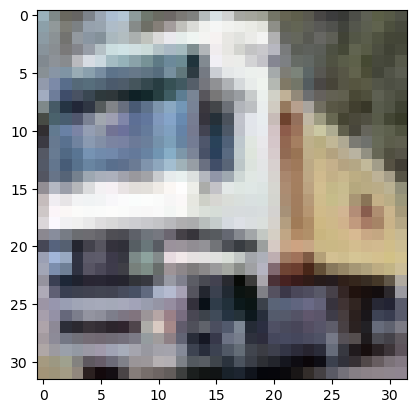

In [6]:
item,label=cifar_trainset[1]
plt.imshow(item.permute(1,2,0))
print(cifar_trainset.classes[label])

******a lot of transformation can lead to decrease the accuracy

In [7]:
train_transforms=tf.Compose([tf.RandomCrop(32,padding=4,padding_mode='reflect'),
                            tf.RandomHorizontalFlip(),
                            tf.ToTensor(),
                            tf.Normalize(means,stds,inplace=True) ])

In [8]:
valid_transforms = tf.Compose([tf.ToTensor(), tf.Normalize(means,stds,inplace=True)])

In [10]:
train_ds = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=train_transforms)
valid_ds = torchvision.datasets.CIFAR10(root='../data', train=False,
                                        download=True, transform=valid_transforms)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


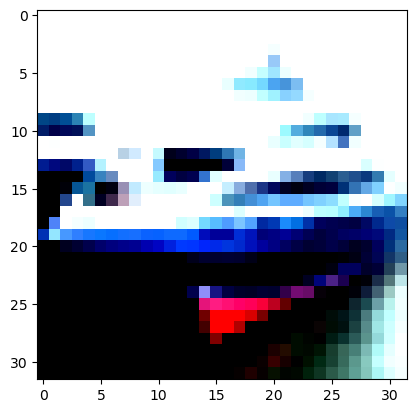

In [11]:
img,lab = valid_ds[1]
plt.imshow(img.permute(1,2,0))
print(valid_ds.classes[lab])

we are using denormalization to show images from dataloader and as the data loader is 4d so for multiplying and adding std and mean we need to reshape them to 4d

In [12]:
batch_size=400
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=2,pin_memory=True)
valid_dl=DataLoader(valid_ds,batch_size*2,num_workers=2,pin_memory=True)

In [13]:
def denormalize(img,means,stds):
  means=torch.tensor(means).reshape(1,3,1,1)
  stds=torch.tensor(stds).reshape(1,3,1,1)
  return img*stds + means

train_dl is 4 dimension tensor , but make_grid is not hence we can use permute(1,2,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


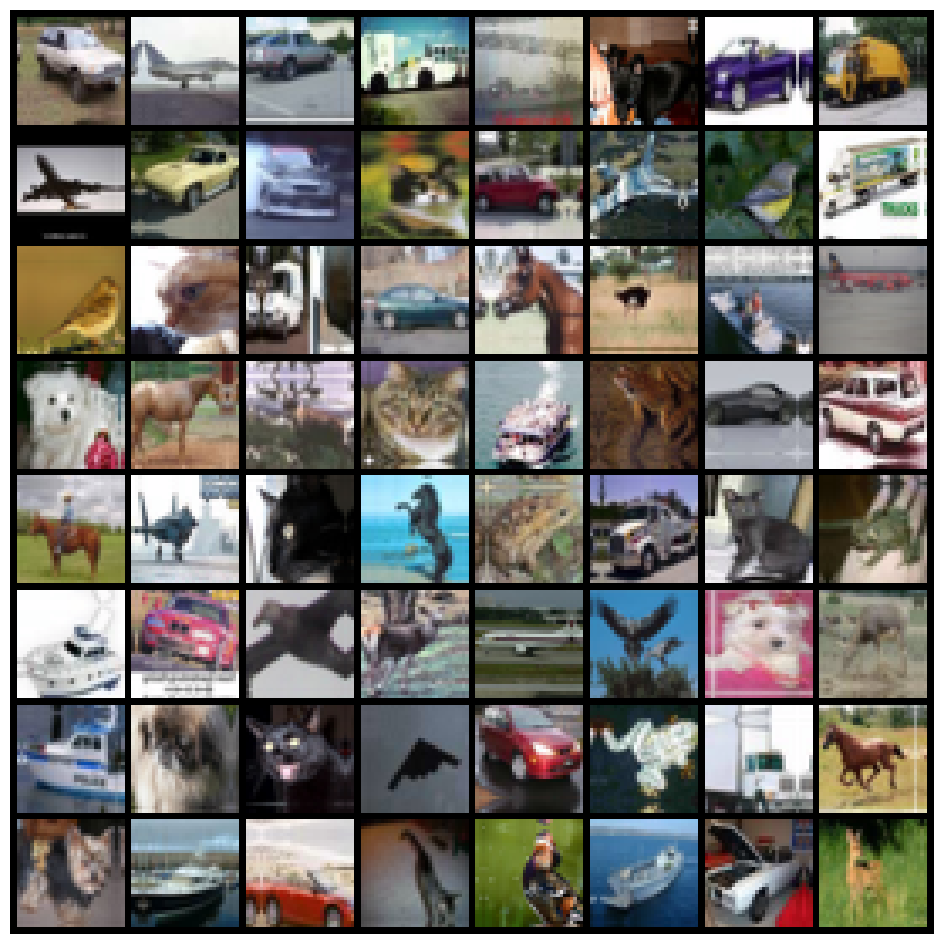

In [14]:
img,lab = next(iter(train_dl))
plt.figure(figsize=(12,12))
plt.axis('off')
deno_img=denormalize(img,means,stds)
plt.imshow(make_grid(deno_img[:64],nrow=8).permute(1,2,0))


In [15]:
a=make_grid(deno_img[:64],nrow=8).permute(1,2,0)
print(img.shape)
a.shape

torch.Size([400, 3, 32, 32])


torch.Size([274, 274, 3])

In [16]:
def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceLoading:
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    def __iter__(self):
        for x in self.dl:
            yield to_device(x,self.device)
    def __len__(self):
        return len(self.dl)
        

In [17]:
device

device(type='cuda', index=0)

In [18]:
train_dl=DeviceLoading(train_dl,device)
valid_dl=DeviceLoading(valid_dl,device)

NOTE-Keeping same output channels is must for resnet to add x later tensor should be of same shape

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Loss_Acc(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self.forward(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self.forward(images)                    
        acc = accuracy(out, labels)           
        return acc
    

# Skip connection 

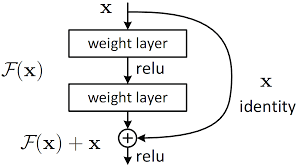

In [18]:
def Add_layers(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(Loss_Acc):
    def __init__(self, in_channels, num_classes): 
        super(ResNet9,self).__init__()
#         400x3x32x32
        self.conv1=Add_layers(in_channels, 64) # 400x64x32x32
        self.conv2=Add_layers(64, 128, pool=True) # 400x128x16x16
        self.res1=nn.Sequential(Add_layers(128, 128), Add_layers(128, 128))
        
        self.conv3=Add_layers(128, 256, pool=True)  # 400x256x8x8
        self.conv4=Add_layers(256, 512, pool=True)  # 400x512x4x4
        self.res2=nn.Sequential(Add_layers(512, 512), Add_layers(512, 512))
        
        self.classifier=nn.Sequential(nn.MaxPool2d(4), # 400x512x1x1
                                        nn.Flatten(), # 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out=self.conv1(xb)
        out=self.conv2(out)
        out=self.res1(out) + out
        out=self.conv3(out)
        out=self.conv4(out)
        out=self.res2(out) + out
        out=self.classifier(out)
        return out

In [20]:
vgg_19 = [64,64,'M',128,128,'M',256,256,256,256,'M',512,512,512,512,'M',512,512,512,512,'M']
VGG_11 = [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"]
VGG_13 = [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"]
vgg_19 = [64,64,'M',128,128,'M',256,256,256,'M',512,512,512,'M',512,512,512,'M']


# VGG19 Architecture

![](https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs42979-020-00373-y/MediaObjects/42979_2020_373_Fig3_HTML.png)

In [21]:
class vgg(Loss_Acc):
    def __init__(self,in_channels,num_classes):
        super(vgg,self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.conv = self.conv_layers(VGG_11)   
        self.full = self.fullcl()
                      
    def forward(self,inp):
        out = self.conv(inp)
        out = out.reshape(out.shape[0],-1)
        out = self.full(out)
        return out
        
    def conv_layers(self,architecture):
        layers = []
        in_channels = self.in_channels
        for x in architecture:
            if type(x) == int:
                out_channels=x
                layers  += [nn.Conv2d(in_channels = in_channels, out_channels = out_channels,
                                  kernel_size = (3,3),stride = (1,1), padding = (1,1)),
                       nn.BatchNorm2d(x), nn.ReLU()]
                in_channels = x
                
            else:
                layers += [nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))]

                
        return nn.Sequential(*layers)
    
    def fullcl(self):
        layers = []
        layers += [nn.Linear(512,4096),
              nn.ReLU(),
              nn.Dropout(0.5),
              nn.Linear(4096,4096),
              nn.ReLU(),
              nn.Dropout(0.5),
              nn.Linear(4096,self.num_classes)]
        
        return nn.Sequential(*layers)

In [22]:
torch.cuda.empty_cache()
# model=to_device(ResNet9(3, 10), device)
model2=to_device(vgg(3,10),device) 



In [23]:
@torch.no_grad()
def evaluation(model,val_loader,t_loss,lrs):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    epoch_acc = torch.stack([x for x in outputs]).mean().item()
    return epoch_acc

In [24]:
def new_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [25]:
def fit(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt=torch.optim.Adam):
    torch.cuda.empty_cache()
    optimizer=opt(model.parameters(),max_lr,weight_decay=weight_decay)
    #every epoch has different lr in OneCycleLR
    lr_sched=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))

    records=[]
    for epoch in range(epochs):
        model.train()
        lrs=[]
        train_losses=[]
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(new_lr(optimizer))
            lr_sched.step()
        
        t_loss = torch.stack(train_losses).mean().item()
        lrs = lrs
        result = evaluation(model, val_loader,t_loss,lrs)
        records.append([result,t_loss,lrs[-1]])
        print(f"result:{result},t_loss:{t_loss},lrs:{lrs[-1]}")
    
    return records
    

# Resnet and VGG19 are tested below

***You can also try vgg11, vgg13m vgg16 by just passing list provided above or you can also try any other vgg architecture by just adding layers list of your own.***

In [25]:
%%time
rec=fit(20,0.01,model,train_dl,valid_dl,1e-4,0.1)

result:0.5716345310211182,t_loss:1.5106046199798584,lrs:0.0010347147065464194
result:0.6614423394203186,t_loss:1.0040816068649292,lrs:0.0027883855836428892
result:0.6706730723381042,t_loss:0.8299049735069275,lrs:0.005189933488862935
result:0.6834615468978882,t_loss:0.7568966150283813,lrs:0.007594185749005899
result:0.801153838634491,t_loss:0.6867470741271973,lrs:0.00935524316949251
result:0.6837499141693115,t_loss:0.5767598152160645,lrs:0.01
result:0.7913461923599243,t_loss:0.48659902811050415,lrs:0.009874640062350875
result:0.772980809211731,t_loss:0.4575282335281372,lrs:0.009504846320134737
result:0.8086537718772888,t_loss:0.42260292172431946,lrs:0.0089091617757105
result:0.7980770468711853,t_loss:0.39063405990600586,lrs:0.008117456539497631
result:0.8100000023841858,t_loss:0.3637279272079468,lrs:0.007169430017913008
result:0.844903826713562,t_loss:0.33996719121932983,lrs:0.0061126202193628925
result:0.8536538481712341,t_loss:0.3108261823654175,lrs:0.00500002
result:0.868076920509338

In [26]:
%%time
rec=fit(20,0.001,model2,train_dl,valid_dl,1e-4,0.1)

KeyboardInterrupt: 